In [1]:
import numpy as np
import pandas as pd
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

### ACS 1

In [2]:
## All initial ACS files
acs_2011 = pd.read_csv('data/acs/acs_5yr_2011_ep.csv')
acs_2012 = pd.read_csv('data/acs/acs_5yr_2012_ep.csv')
acs_2013 = pd.read_csv('data/acs/acs_5yr_2013_ep.csv')
acs_2014 = pd.read_csv('data/acs/acs_5yr_2014_ep.csv')
acs_2015 = pd.read_csv('data/acs/acs_5yr_2015_ep.csv')
acs_2016 = pd.read_csv('data/acs/acs_5yr_2016_ep.csv')
acs_2017 = pd.read_csv('data/acs/acs_5yr_2017_ep.csv')
acs_2018 = pd.read_csv('data/acs/acs_5yr_2018_ep.csv')


In [3]:
# print number of zipcodes in each acs file
file_list = [acs_2011, acs_2012, acs_2013, acs_2014, acs_2015, acs_2016, acs_2017, acs_2018]
for idx, df in enumerate(file_list):
    print(len(df['geo_id'].unique()), end=', ')

215, 215, 215, 215, 215, 215, 215, 215, 

In [4]:
## Fill in year column
file_list = [acs_2011, acs_2012, acs_2013, acs_2014, acs_2015, acs_2016, acs_2017, acs_2018]
for idx, df in enumerate(file_list):
    df['year'] = '201' + str(idx +1)

In [5]:
## Create one master file of all acs dataframes
acs_master = pd.concat(file_list, axis=0, ignore_index=True)
acs_master['year'] = acs_master['year'].astype('int')

<AxesSubplot:>

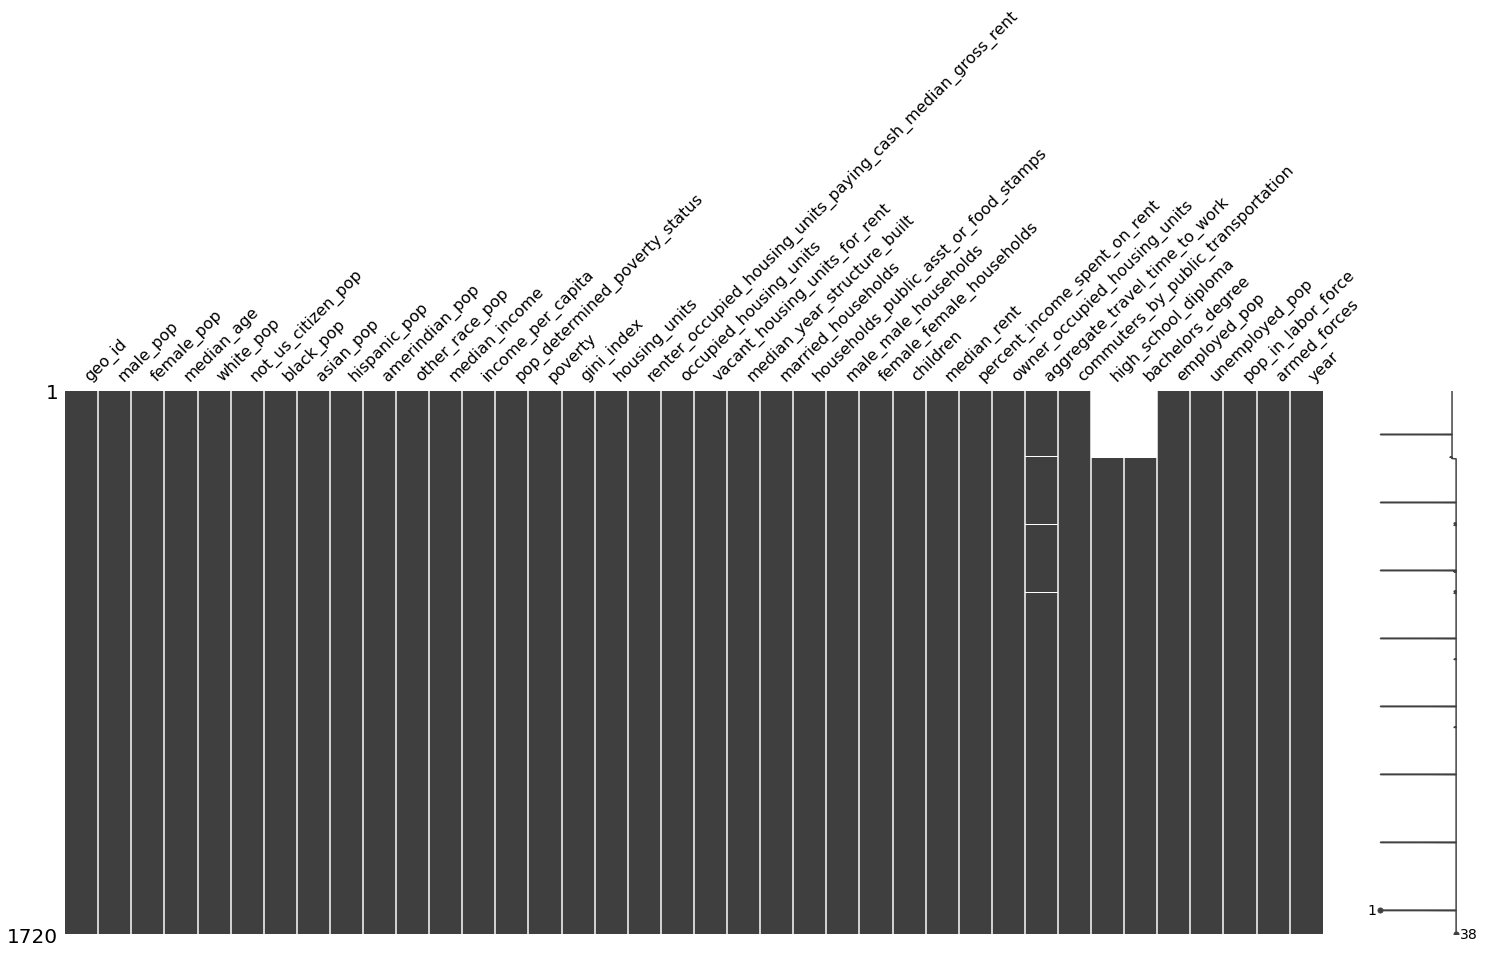

In [6]:
## Check missing values
msno.matrix(acs_master)

In [7]:
## No fully empty columns left

acs_master = acs_master.dropna(thresh=10)
acs_master[acs_master.isnull().all(axis=1)]


,geo_id,male_pop,female_pop,median_age,white_pop,not_us_citizen_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,...,owner_occupied_housing_units,aggregate_travel_time_to_work,commuters_by_public_transportation,high_school_diploma,bachelors_degree,employed_pop,unemployed_pop,pop_in_labor_force,armed_forces,year


In [8]:
## Check columns with some NA
missing_vals = acs_master.isnull().any()
missing_vals = missing_vals[missing_vals == True]
missing_vals

aggregate_travel_time_to_work    True
high_school_diploma              True
bachelors_degree                 True
dtype: bool

<AxesSubplot:xlabel='aggregate_travel_time_to_work', ylabel='Count'>

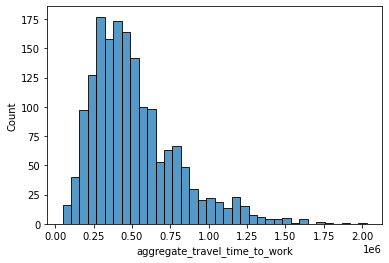

In [9]:
## travel time to work
sns.histplot(data = acs_master['aggregate_travel_time_to_work'])

In [10]:
# acs_master.isna().sum()

### Deal with missing travel time

In [11]:
missing_traveltime_zips = list(acs_master[acs_master['aggregate_travel_time_to_work'].isna()]['geo_id'])
missing_traveltime_zips

[78756.0, 78701.0, 78756.0, 75039.0, 78701.0, 78756.0, 78701.0, 78701.0]

In [12]:
# ## impute  values for travel time to work - mean - DIDNT WORK
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_output = imp.fit(acs_master[['aggregate_travel_time_to_work']])
# acs_master[['aggregate_travel_time_to_work']] = pd.DataFrame(imp.transform(acs_master[['aggregate_travel_time_to_work']]))
# # imp_output = pd.DataFrame(imp.transform(acs_master[['aggregate_travel_time_to_work']]))
# # acs_master[['aggregate_travel_time_to_work']] = imp_output
# acs_master[['aggregate_travel_time_to_work']] = pd.DataFrame(imp.fit_transform(acs_master[['aggregate_travel_time_to_work']]))



In [13]:
## fill travel times with median
acs_master['aggregate_travel_time_to_work'].fillna(int(acs_master['aggregate_travel_time_to_work'].median()), inplace=True)


### Deal with missing education

In [14]:
## both high_school_diploma and bachelors_degree were not collected in 2011, fill in using linear regressed mean
missing_ed = acs_master[acs_master['high_school_diploma'].isna()]
missing_ed = acs_master[acs_master['bachelors_degree'].isna()]

<AxesSubplot:xlabel='year', ylabel='high_school_diploma'>

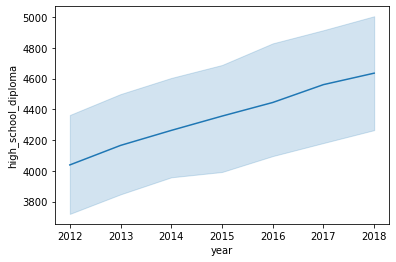

In [15]:
sns.lineplot(data=acs_master, x="year", y="high_school_diploma")

<AxesSubplot:xlabel='year', ylabel='bachelors_degree'>

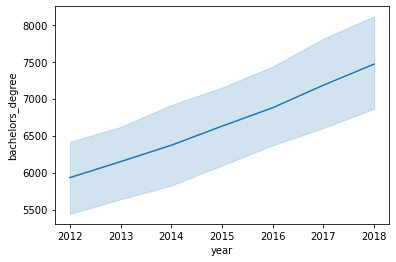

In [16]:
sns.lineplot(data=acs_master, x="year", y="bachelors_degree")

In [17]:
X_after2012 = acs_master[acs_master['year']>=2012][['year', 'geo_id']]
y_after2012 = acs_master[acs_master['year']>=2012]['bachelors_degree']
print(f'X shape: {X_after2012.shape}')
print(f'y shape: {y_after2012.shape}')

X shape: (1498, 2)
y shape: (1498,)


In [18]:
X_2011 = acs_master[acs_master['year']==2011][['year', 'geo_id']]
print(f'X shape: {X_2011.shape}')

X shape: (214, 2)


In [19]:
lr = LinearRegression()
lr.fit(X_after2012, y_after2012)
acs_master.loc[acs_master['bachelors_degree'].isna(),'bachelors_degree'] = lr.predict(X_2011)

In [20]:
X_after2012 = acs_master[acs_master['year']>=2012][['year', 'geo_id']]
y_after2012 = acs_master[acs_master['year']>=2012]['high_school_diploma']
print(f'X shape: {X_after2012.shape}')
print(f'y shape: {y_after2012.shape}')

X_2011 = acs_master[acs_master['year']==2011][['year', 'geo_id']]
print(f'X shape: {X_2011.shape}')

lr = LinearRegression()
lr.fit(X_after2012, y_after2012)
acs_master.loc[acs_master['high_school_diploma'].isna(),'high_school_diploma'] = lr.predict(X_2011)

X shape: (1498, 2)
y shape: (1498,)
X shape: (214, 2)


In [21]:
# sns.regplot(data=acs_master, x='year', y = 'bachelors_degree')

<AxesSubplot:xlabel='year', ylabel='bachelors_degree'>

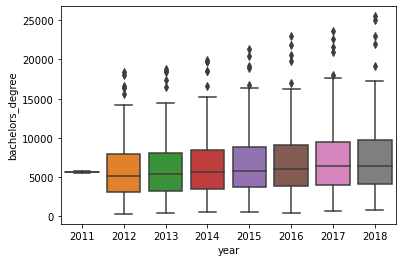

In [22]:
sns.boxplot(data=acs_master, x='year', y = 'bachelors_degree')

<AxesSubplot:xlabel='year', ylabel='high_school_diploma'>

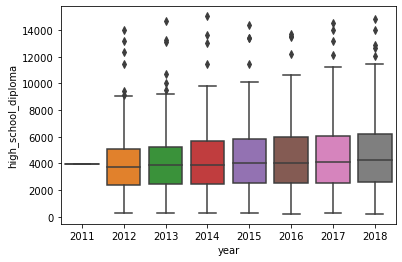

In [23]:
sns.boxplot(data=acs_master, x='year', y = 'high_school_diploma')

In [24]:
## impute bachelors_degree and highschool_degree using 2012 numbers

acs_master = acs_master.sort_values('year', ascending=True)
acs_master['bachelors_degree'] = acs_master['bachelors_degree'].fillna(acs_master['bachelors_degree']).median()

In [25]:
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_output = imp.fit(acs_master[['high_school_diploma']])
# imp_output = pd.DataFrame(imp.transform(acs_master[['high_school_diploma']]))

In [26]:
acs_master.sort_values('year', inplace=True)

### Add monthly dates to dataframe

In [27]:
# Create list of dates from 01-01-2012 to most recent in covid data
dates_list = []
new_date = pd.to_datetime('01-01-2011')
end_date = pd.to_datetime('08-01-2021')

while new_date != end_date:
    dates_list.append(new_date)
    new_date += pd.DateOffset(months=1)
dates = pd.DataFrame(dates_list)
dates.columns = ['Time']
dates['year'] = dates['Time'].dt.year
# dates['year'] = dates['year'].astype('int')

In [28]:
dates

,Time,year
0,2011-01-01,2011
1,2011-02-01,2011
2,2011-03-01,2011
3,2011-04-01,2011
4,2011-05-01,2011
...,...,...
122,2021-03-01,2021
123,2021-04-01,2021
124,2021-05-01,2021
125,2021-06-01,2021


In [29]:
## merge ACS with dates list
acs_master = acs_master.merge(dates, how='left', on='year')
acs_master = acs_master.rename(columns={'geo_id':'zip_code'})

In [33]:
acs_master.isna().sum()

zip_code                                                       0
male_pop                                                       0
female_pop                                                     0
median_age                                                     0
white_pop                                                      0
not_us_citizen_pop                                             0
black_pop                                                      0
asian_pop                                                      0
hispanic_pop                                                   0
amerindian_pop                                                 0
other_race_pop                                                 0
median_income                                                  0
income_per_capita                                              0
pop_determined_poverty_status                                  0
poverty                                                        0
gini_index               

### Save

In [34]:
# acs_master.to_csv('acs_clean.csv')

In [31]:
# ## Check it
# msno.matrix(acs_master)

In [32]:
STOP

NameError: name 'STOP' is not defined

### Process second ACS info

In [ ]:
acs2 = pd.read_csv('data/acs/2nd_census_data.csv')

In [ ]:
acs2.columns

In [ ]:
acs2 = acs2.rename(columns={'end_year': 'year', 'ZCTA':'zip_code'})
acs2 = acs2.drop(columns=['acs_type', 'start_year', 'state'], axis=1)

In [ ]:
msno.matrix(acs2)

In [ ]:
missing_vals = acs2.isnull().any()

In [ ]:
## Drop empty columns

# null_cols = pd.DataFrame(acs2.isna().all(), columns=['T_F']).reset_index()
null_cols = pd.DataFrame(acs2.isna().all(), columns=['T_F']).reset_index()
null_cols = null_cols[null_cols['T_F'] == True] 
null_cols['index']
acs2 = acs2.drop(columns=null_cols['index'], axis=1)

In [ ]:
msno.matrix(acs2)

In [ ]:
# acs2 = acs2.dropna(thresh=10)
## Drop empty columns

some_missing = pd.DataFrame(acs2.isna().any(), columns=['T_F']).reset_index()
some_missing = some_missing[some_missing['T_F'] == True]
some_missing

In [ ]:

# null_cols['index']
# acs2 = acs2.drop(columns=null_cols['index'], axis=1)

missing_sums = acs2.isna().sum()/len(acs2)
missing_sums = missing_sums[missing_sums > 0]
missing_sums
# some_missing['num_missing'] = missing_sums[some_missing['index']], axis=1

In [ ]:
acs2.columns.to_list()

In [ ]:
acs2['housing_units_built_2010_to_2014'][]

In [ ]:
sns.scatterplot(data=acs_master, x='year', y = 'housing_units_built_2010_to_2014')

In [ ]:
miss_more_than_half = missing_sums[missing_sums > 0.5]
miss_more_than_half.reset_index()
miss_more_than_half = miss_more_than_half.index.to_list()

In [ ]:
## drop columns where more than half is missing
acs2 = acs2.drop(columns=miss_more_than_half, axis=1)

In [ ]:
msno.matrix(acs2)

In [ ]:
some_missing

In [ ]:
missing_sums = acs2.isna().sum()

In [ ]:
missing_sums['male_64_to_65']

In [ ]:
msno.matrix(acs2)

In [ ]:
[null_cols

In [ ]:
acs2.isna().all()

In [ ]:
acs2 = set(buh.columns)
buh_col

In [ ]:
buh2 = set(acs_master.columns)
buh2

In [ ]:
print(buh_col-buh2)

In [ ]:
print(buh2-buh_col)

In [ ]:
# Create list of dates from 01-01-2012 to most recent in covid data
dates_list = []
new_date = pd.to_datetime('01-01-2011')
end_date = pd.to_datetime('08-01-2021')

while new_date != end_date:
    dates_list.append(new_date)
    new_date += pd.DateOffset(months=1)
dates = pd.DataFrame(dates_list)
dates.columns = ['Time']
dates['year'] = dates['Time'].dt.year
# dates['year'] = dates['year'].astype('int')

In [ ]:
## merge ACS with dates list
acs2_master = acs2.merge(dates, how='left', on='year')
# acs2_master = acs2_master.rename(columns={'geo_id':'zip_code'})
acs2_master = acs2_master.drop('year', axis=1)

In [ ]:
acs2_master

In [ ]:
msno.matrix(acs2)

In [ ]:
# acs_master.to_csv('acs_master11to18_clean.csv')